# Retrieve Stock Data and Save to DF

In [1]:
from pandas_datareader import data as web
import os
import pandas as pd
import yfinance as yf

def get_stock(ticker, start_date, end_date, s_window, l_window):
    try:
        #yf.pdr_override()
        df = yf.download(ticker, start=start_date, end=end_date,auto_adjust=False)
        #print("DF: ",df)
# can use this as well        df = web.get_data_yahoo(ticker, start=start_date, end=end_date)
        df['Return'] = df['Adj Close'].pct_change()
        df['Return'].fillna(0, inplace = True)
        df['Date'] = df.index
        df['Date'] = pd.to_datetime(df['Date'])
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year 
        df['Day'] = df['Date'].dt.day
        for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
            df[col] = df[col].round(2)
        df['Weekday'] = df['Date'].dt.day_name()
        df['Week_Number'] = df['Date'].dt.strftime('%U')
        df['Year_Week'] = df['Date'].dt.strftime('%Y-%U')
        df['Short_MA'] = df['Adj Close'].rolling(window=s_window, min_periods=1).mean()
        df['Long_MA'] = df['Adj Close'].rolling(window=l_window, min_periods=1).mean()        
        col_list = ['Date', 'Year', 'Month', 'Day', 'Weekday', 
                    'Week_Number', 'Year_Week', 'Open', 
                    'High', 'Low', 'Close', 'Volume', 'Adj Close',
                    'Return', 'Short_MA', 'Long_MA']
        num_lines = len(df)
        df = df[col_list]
        print('read ', num_lines, ' lines of data for ticker: ' , ticker)
        return df
    except Exception as error:
        print(error)
        return None

In [2]:
try:
    ticker='SPY'
    input_dir = os.getcwd()
    output_file = os.path.join(input_dir, ticker + '.csv')
    df = get_stock(ticker, start_date='2000-01-01', end_date='2025-07-08', 
               s_window=14, l_window=50)
    df.to_csv(output_file, index=False)
    print('wrote ' + str(len(df)) + ' lines to file: ' + output_file)
except Exception as e:
    print(e)
    print('failed to get Yahoo stock data for ticker: ', ticker)

[*********************100%***********************]  1 of 1 completed

read  6415  lines of data for ticker:  SPY
wrote 6415 lines to file: /Users/jonathanyan/Desktop/RISE DS/DS-Prac/Stock_market_proj/lstm-atr-prediction/stock-data/SPY.csv



/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)


In [3]:
#psuedocode
'''
1. create ATR column
2. create SD column
3. build LSTM columnn
4. split into train and test
5. train lstm on training data for ATR and test
6. train lstm on training data for SD and test
7. plot results and avg. returns based on decisions (buy if delta_volatility<-alpha, sell if delta_volatility>alpha)
'''

'\n1. create ATR column\n2. create SD column\n3. build LSTM columnn\n4. split into train and test\n5. train lstm on training data for ATR and test\n6. train lstm on training data for SD and test\n7. plot results and avg. returns based on decisions (buy if delta_volatility<-alpha, sell if delta_volatility>alpha)\n'

In [4]:
 #.xs returns a cross section; selects only values within the SPY indexes at level=1
df_n= df.xs('SPY',axis=1,level=1)
#cleaned up data

In [5]:
# import math
# #challenge of how to deal with missing values in time series data
# #choose sliding window of length=N (could be 20?) N_lstmtraining>N_atrslidingwindow
# def atr_func(d):
#     running = 0
#     for i in range(len(d)):
#         high = d.loc[i,"High"]
#         low = d.loc[i,"Low"]
#         if i==0:
#             running += high-low
#             continue
#         if i>0:
#             y_close = d.loc[i,"Close"]
        
#         TR = max(high-low,max(math.abs(high-y_close),math.abs(low-y_close)))
#         running+=TR
#     return running/len(d)

# df_n['ATR'] = df_n.rolling(window=14).apply(atr_func)
# df_n

In [6]:
#define ATR columns
high = df_n["High"]
low = df_n["Low"]
close = df_n["Close"]

prev_close = close.shift(1)


tr = pd.concat([
    high - low,
    (high - prev_close).abs(),
    (low - prev_close).abs()
], axis=1).max(axis=1)

df_n["ATR"] = tr.rolling(7).mean()

/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/4206602609.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()


In [7]:
import numpy as np

log_diff = np.log(df_n["Close"]/df_n["Close"].shift(1))
df_n["SD_Log_Close"] = log_diff.rolling(7).std()
df_n["ATR_normalized"] = (df_n["ATR"] - df_n["ATR"].mean())/df_n["ATR"].std()
df_n["SD_normalized"] = (df_n["SD_Log_Close"] - df_n["SD_Log_Close"].mean())/df_n["SD_Log_Close"].std()
#xlb, xle, 

/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2394309760.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["SD_Log_Close"] = log_diff.rolling(7).std()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2394309760.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR_normalized"] = (df_n["ATR"] - df_n["ATR"].mean())/df_n["ATR"].std()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2394309760.py:6: SettingWithCopyWarning: 
A value is trying to b

In [8]:
#drop na values (first 6 rows)
df_n = df_n.dropna()
df_n = df_n.reset_index()

In [9]:
(df_n.loc[1,"Date"] - df_n.loc[0,"Date"]).days

# log(c_n+1/c_c)

1

In [10]:
df_n["Delta_Days"] = [(df_n.loc[i,"Date"] - df_n.loc[0,"Date"]).days for i in range(len(df_n))]
#save clean data
df_n.to_csv("Clean_Data.csv")

In [11]:
#define lstm model
import torch
from torch.nn import *
import torch.nn.functional as F

class NN_LSTM(Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.lstm = LSTM(input_size=input_size,hidden_size=30)
        self.fc = Linear(30,output_size)
    def activation(self,X):
        return F.relu(X)
    def forward(self,input):
        input,_ = self.lstm(input)
        input = self.fc(input[-1,:,:])
        return input #return the last prediction
#lstm_layer = LSTM(input_size=4,hidden_size=30)

In [12]:
#define PDE loss
def PDE_loss(v_hat):
    return 0
    #use torch.autograd to get PDE loss

In [13]:
df_n

Price,Date,Open,High,Low,Close,Volume,Adj Close,ATR,SD_Log_Close,ATR_normalized,SD_normalized,Delta_Days
0,2000-01-12,144.59,144.59,142.88,143.06,6907700,90.64,4.024286,0.029618,0.422870,2.622685,0
1,2000-01-13,144.47,145.75,143.28,145.00,5158300,91.87,3.580000,0.024822,0.247398,1.979539,1
2,2000-01-14,146.53,147.47,145.97,146.97,7437300,93.11,3.321429,0.024942,0.145274,1.995695,2
3,2000-01-18,145.34,146.62,145.19,145.81,6488500,92.38,3.040000,0.023834,0.034123,1.847051,6
4,2000-01-19,145.31,147.00,145.00,147.00,6157900,93.13,2.182857,0.011098,-0.304408,0.139264,7
...,...,...,...,...,...,...,...,...,...,...,...,...
6403,2025-06-30,617.38,619.22,615.04,617.85,92502500,617.85,5.868571,0.005666,1.151276,-0.589089,9301
6404,2025-07-01,616.36,618.83,615.52,617.65,70030100,617.65,5.398571,0.004345,0.965648,-0.766251,9302
6405,2025-07-02,617.24,620.49,616.61,620.45,66510400,620.45,4.717143,0.003906,0.696516,-0.825029,9303
6406,2025-07-03,622.45,626.28,622.43,625.34,51065800,625.34,4.450000,0.003185,0.591007,-0.921698,9304


In [14]:
def tt_split(df_n,vol_metric):
    train = df_n.loc[[i<=len(df_n)*4/5 for i in range(len(df_n))]]
    X_train = train[["Open","Close","High","Low", vol_metric]].to_numpy()
    y_train = train[vol_metric].to_numpy()

    test = df_n.loc[[i>len(df_n)*4/5 for i in range(len(df_n))]]
    X_test = test[["Open","Close","High","Low", vol_metric]].to_numpy()
    y_test = test[vol_metric].to_numpy()
    return X_train,y_train,X_test,y_test

X_train,y_train,X_test,y_test = tt_split(df_n,"ATR_normalized")

#bollinger bands
#try moving median instead of moving average
#try moving quartiles instead of std; q3-q2  *1/2
#take longer time period - five years

#lstm,cnn,and rnn cant either predict directional volatiliy for xl stocks


In [15]:
def make_seq(X_train,y_train,X_test,y_test):
    T = 30  # sequence length (window size)
    X_seq = []
    y_seq = []
    X_seq_test = []
    y_seq_test = []

    for i in range(len(X_train) - T):
        X_seq.append(X_train[i:i+T])  # shape: [T, 4] <- what is wanted in lstm
        y_seq.append(y_train[i+T])    # predict next ATR value
    for i in range(len(X_test)-T):    
        X_seq_test.append(X_test[i:i+T])
        y_seq_test.append(y_test[i+T])


    X_seq = torch.tensor(X_seq, dtype=torch.float32)
    y_seq = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(1)
    X_seq_test = torch.tensor(X_seq_test, dtype=torch.float32)
    y_seq_test = torch.tensor(y_seq_test, dtype=torch.float32).unsqueeze(1)
    
    return X_seq,y_seq,X_seq_test,y_seq_test
X_seq,y_seq,X_seq_test,y_seq_test = make_seq(X_train,y_train,X_test,y_test)

/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1606808691.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  X_seq = torch.tensor(X_seq, dtype=torch.float32)


In [16]:
from torch.utils.data import DataLoader, TensorDataset

def create_loaders(X_seq,y_seq,X_seq_test,y_seq_test,batch_size=64):
    dataset = TensorDataset(X_seq, y_seq)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    dataset_test = TensorDataset(X_seq_test,y_seq_test)
    loader_test = DataLoader(dataset_test,batch_size=batch_size,shuffle=True)
    return loader,loader_test
loader,loader_test = create_loaders(X_seq,y_seq,X_seq_test,y_seq_test)

In [17]:
#training loop
model = NN_LSTM(input_size=5,output_size=1)
epochs = 100
optim = torch.optim.Adam(params = model.parameters())
crit = MSELoss()
losses = []
losses_test = []

for i in range(epochs):
    running_loss = 0
    for x_window,y_atr in loader:
        #print("Running")
        input = x_window.permute(1,0,2) #shape = [seq_length,batch_length,4]
        out = model(input)
        #print(y_atr.shape)
        #print(out,y_atr)
        #break
        loss = crit(out,y_atr)
        running_loss+=loss.item()
        optim.zero_grad()
        loss.backward()
        optim.step()
            # could try loss += (i+1)/period/sum(j/period for j in range(period))crit(out,y_train[i]); adds a coeff to give more weigt to recent ones
    #break
    running_loss/=(len(loader))
    print(f"Training Loss: {running_loss}")
    losses.append(running_loss)

    with torch.no_grad():
        testing_loss = 0
        for x_window_test,y_atr_test in loader_test:
            out_test = model(x_window_test.permute(1,0,2))
            #print(y_atr_test.shape)
            loss = crit(out_test,y_atr_test)
            testing_loss+=loss.item()
        losses_test.append(testing_loss/(len(loader_test)))
    


Training Loss: 0.3747916261665523
Training Loss: 0.3251064454205334
Training Loss: 0.266295773582533
Training Loss: 0.2675056715030223
Training Loss: 0.16731027278583496
Training Loss: 0.11331336114672012
Training Loss: 0.10446787308901548
Training Loss: 0.0918959783972241
Training Loss: 0.084267945389729
Training Loss: 0.07983294712612406
Training Loss: 0.07635890239034779
Training Loss: 0.07216371713439003
Training Loss: 0.06724960973951966
Training Loss: 0.06032604240463115
Training Loss: 0.055217031098436564
Training Loss: 0.05253738011233509
Training Loss: 0.04894062851672061
Training Loss: 0.048281172622228044
Training Loss: 0.04620970716350712
Training Loss: 0.04403288284665905
Training Loss: 0.04067908056313172
Training Loss: 0.03864215846406296
Training Loss: 0.035321569856023416
Training Loss: 0.036196485062828285
Training Loss: 0.0334266546939034
Training Loss: 0.034560847643297164
Training Loss: 0.03332744287326932
Training Loss: 0.027906385855749248
Training Loss: 0.031741

Text(0.5, 1.0, 'Training Loss of LSTM (ATR_normalized) across 60 epochs')

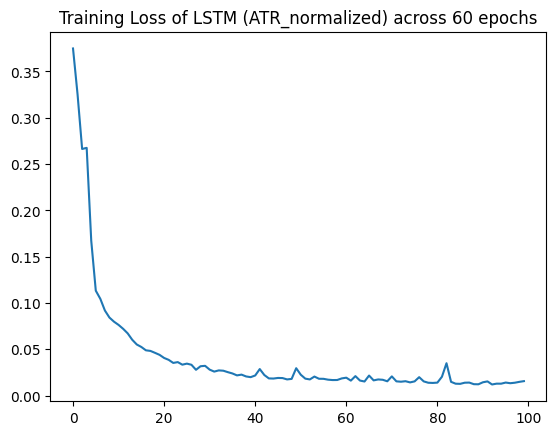

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=[i for i in range(len(losses))],y=losses)
plt.title("Training Loss of LSTM (ATR_normalized) across 60 epochs")

Text(0.5, 1.0, 'Testing Loss of LSTM (ATR_normalized) across 60 epochs')

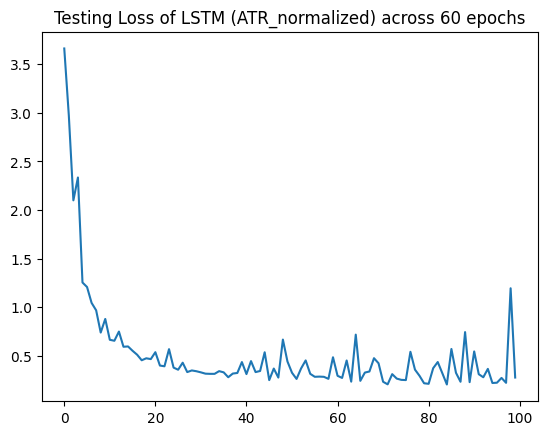

In [19]:
sns.lineplot(losses_test)
plt.title("Testing Loss of LSTM (ATR_normalized) across 60 epochs")

In [20]:
X_train_sd,y_train_sd,X_test_sd,y_test_sd = tt_split(df_n,vol_metric="SD_normalized")
X_seq_sd,y_seq_sd,X_seq_test_sd,y_seq_test_sd = make_seq(X_train_sd,y_train_sd,X_test_sd,y_test_sd)
loader_sd,loader_test_sd = create_loaders(X_seq_sd,y_seq_sd,X_seq_test_sd,y_seq_test_sd)

In [21]:
#training loop
model_sd = NN_LSTM(input_size=5,output_size=1)
epochs = 100
optim = torch.optim.Adam(params = model_sd.parameters())
crit = MSELoss()
losses = []
losses_test = []

for i in range(epochs):
    running_loss = 0
    for x_window,y_sd in loader_sd:
        #print("Running")
        input = x_window.permute(1,0,2) #shape = [seq_length,batch_length,4]
        out = model_sd(input)
        #print(y_sd.shape)
        loss = crit(out,y_sd)
        running_loss+=loss.item()
        optim.zero_grad()
        loss.backward()
        optim.step()
            # could try loss += (i+1)/period/sum(j/period for j in range(period))crit(out,y_train[i]); adds a coeff to give more weigt to recent ones
    running_loss/=(len(loader_sd))
    print(f"Training Loss: {running_loss}")
    losses.append(running_loss)

    with torch.no_grad():
        testing_loss = 0
        for x_window_test,y_sd_test in loader_test_sd:
            out_test = model_sd(x_window_test.permute(1,0,2))
            #print(y_sd_test.shape)
            loss = crit(out_test,y_sd_test)
            testing_loss+=loss.item()
        losses_test.append(testing_loss/(len(loader_test_sd)))


Training Loss: 1.2639655835926533
Training Loss: 0.9204729635268449
Training Loss: 0.7369798190891743
Training Loss: 0.5974853264167905
Training Loss: 0.4169171329587698
Training Loss: 0.328044630587101
Training Loss: 0.2504947075154632
Training Loss: 0.21634122664108874
Training Loss: 0.1882872528396547
Training Loss: 0.1806316919159144
Training Loss: 0.1771880228538066
Training Loss: 0.15461942604742945
Training Loss: 0.14915310440119356
Training Loss: 0.14445251757279037
Training Loss: 0.13667050716467202
Training Loss: 0.13570740791037678
Training Loss: 0.13011830095201732
Training Loss: 0.12341327210888267
Training Loss: 0.11916123726405203
Training Loss: 0.11585930134169757
Training Loss: 0.11716702245175839
Training Loss: 0.11007022028788924
Training Loss: 0.12554985163733362
Training Loss: 0.11366351908072829
Training Loss: 0.10603317860513925
Training Loss: 0.10548905292525887
Training Loss: 0.10579362288117408
Training Loss: 0.11481791203841567
Training Loss: 0.10803044941276

Text(0.5, 1.0, 'Training Loss of LSTM (SD__normalized) across 60 epochs')

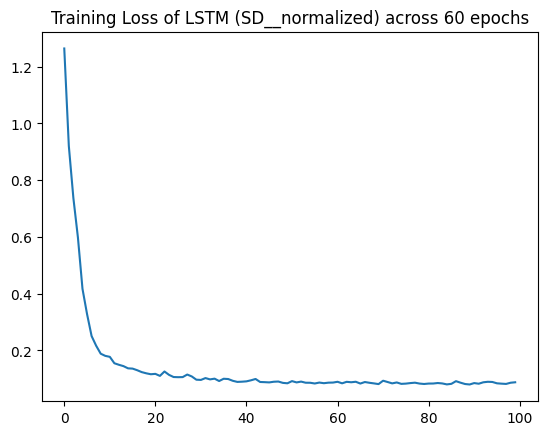

In [22]:
sns.lineplot(losses)
plt.title("Training Loss of LSTM (SD__normalized) across 60 epochs")

Text(0.5, 1.0, 'Testing Loss of LSTM (SD_normalized) across 60 epochs')

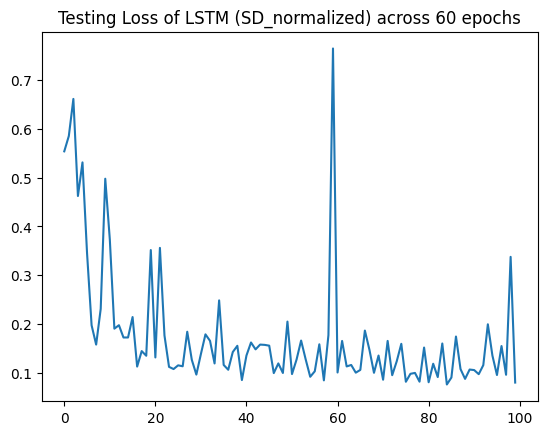

In [23]:
sns.lineplot(losses_test)
plt.title("Testing Loss of LSTM (SD_normalized) across 60 epochs")

In [24]:
#use past atrs
#try transformations of atr log(atr)

In [34]:
def pipeline(ticker,start,end,metric):
    df = get_stock(ticker,start_date=start,end_date=end,s_window=14,l_window=50)
    df_n= df.xs(ticker,axis=1,level=1)
    
        #define ATR columns
    high = df_n["High"]
    low = df_n["Low"]
    close = df_n["Close"]

    prev_close = close.shift(1)


    tr = pd.concat([
        high - low,
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)

    df_n["ATR"] = tr.rolling(7).mean()
    
    log_diff = np.log(df_n["Close"]/df_n["Close"].shift(1))
    df_n["SD_Log_Close"] = log_diff.rolling(7).std()
    df_n["ATR_normalized"] = (df_n["ATR"] - df_n["ATR"].mean())/df_n["ATR"].std()
    df_n["SD_normalized"] = (df_n["SD_Log_Close"] - df_n["SD_Log_Close"].mean())/df_n["SD_Log_Close"].std()

    df_n = df_n.dropna()
    df_n = df_n.reset_index()   

    X_train,y_train,X_test,y_test = tt_split(df_n, metric)

    X_seq,y_seq,X_seq_test,y_seq_test = make_seq(X_train,y_train,X_test,y_test)

    loader,loader_test = create_loaders(X_seq,y_seq,X_seq_test,y_seq_test)

    #training loop
    
    model = NN_LSTM(input_size=5,output_size=1)
    epochs = 100
    optim = torch.optim.Adam(params = model.parameters())
    crit = MSELoss()
    losses = []
    losses_test = []

    for i in range(epochs):
        running_loss = 0
        for x_window,y_atr in loader:
            #print("Running")
            input = x_window.permute(1,0,2) #shape = [seq_length,batch_length,4]
            out = model(input)
            #print(y_atr.shape)
            #print(out,y_atr)
            #break
            loss = crit(out,y_atr)
            running_loss+=loss.item()
            optim.zero_grad()
            loss.backward()
            optim.step()
                # could try loss += (i+1)/period/sum(j/period for j in range(period))crit(out,y_train[i]); adds a coeff to give more weigt to recent ones
        #break
        running_loss/=(len(loader))
        print(f"Training Loss: {running_loss}")
        losses.append(running_loss)

        with torch.no_grad():
            testing_loss = 0
            for x_window_test,y_atr_test in loader_test:
                out_test = model(x_window_test.permute(1,0,2))
                #print(y_atr_test.shape)
                loss = crit(out_test,y_atr_test)
                testing_loss+=loss.item()
            losses_test.append(testing_loss/(len(loader_test)))

    sns.lineplot(x=[i for i in range(len(losses))],y=losses)
    plt.title(f"Training Loss of LSTM ({metric}) across 60 epochs for {ticker}")
    plt.show()

    sns.lineplot(losses_test)
    plt.title(f"Testing Loss of LSTM ({metric}) across 60 epochs for {ticker}")
    plt.show()

    return min(losses),min(losses_test)

    

[*********************100%***********************]  1 of 1 completed
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/416295630.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/416295630.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

read  6419  lines of data for ticker:  SPY
Training Loss: 0.3744391125626862
Training Loss: 0.3477727074176073
Training Loss: 0.3144039283040911
Training Loss: 0.2833936178591102
Training Loss: 0.22682826211676002
Training Loss: 0.1673595410771668
Training Loss: 0.12958139196271076
Training Loss: 0.10470230608480051
Training Loss: 0.0868603165494278
Training Loss: 0.07546323342248798
Training Loss: 0.06822691920679062
Training Loss: 0.062429825629806146
Training Loss: 0.05965691042947583
Training Loss: 0.05450198839535005
Training Loss: 0.051818748010555284
Training Loss: 0.0500749318220187
Training Loss: 0.045631572871934624
Training Loss: 0.04675865831086412
Training Loss: 0.041346690320642664
Training Loss: 0.039927325770258905
Training Loss: 0.03700659123715013
Training Loss: 0.035598899598699066
Training Loss: 0.03426190949394368
Training Loss: 0.034171594172948974
Training Loss: 0.03134026918560266
Training Loss: 0.031500793196028096
Training Loss: 0.029447766637895258
Training L

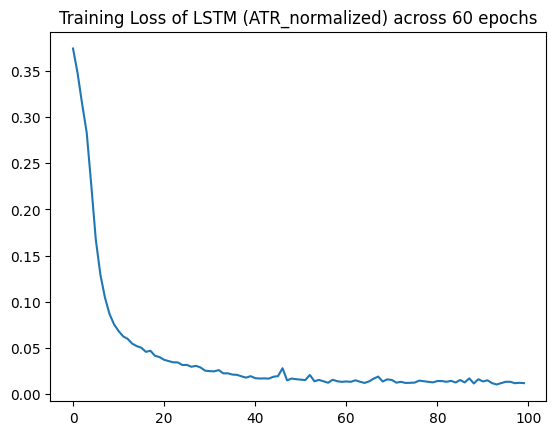

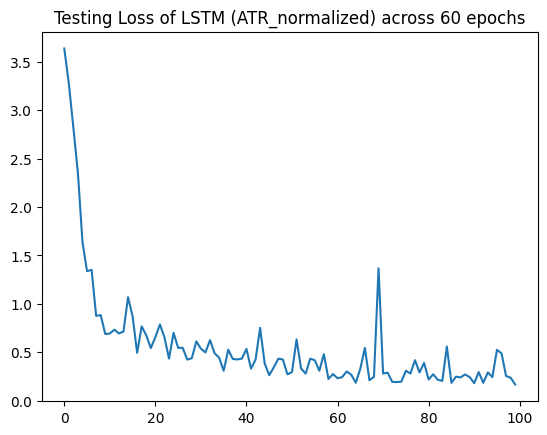

In [26]:
start = "2000-01-01"
end = "2025-07-14"
pipeline("SPY",start,end,metric="ATR_normalized")

[*********************100%***********************]  1 of 1 completed
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/416295630.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/416295630.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

read  6419  lines of data for ticker:  XLP
Training Loss: 0.6635663524735719
Training Loss: 0.4545626400504261
Training Loss: 0.31806099524255843
Training Loss: 0.260136100044474
Training Loss: 0.19983332441188395
Training Loss: 0.14350034203962422
Training Loss: 0.1205315642815549
Training Loss: 0.10618928681360558
Training Loss: 0.09386730592232198
Training Loss: 0.08195506671909243
Training Loss: 0.07317660832195542
Training Loss: 0.067669489455875
Training Loss: 0.06326006867457182
Training Loss: 0.05702971249702386
Training Loss: 0.05038700117729604
Training Loss: 0.04571209580171853
Training Loss: 0.04161530014825985
Training Loss: 0.038856110302731395
Training Loss: 0.03777182241901755
Training Loss: 0.034713066462427375
Training Loss: 0.034588639298453926
Training Loss: 0.03310829935944639
Training Loss: 0.03014568209182471
Training Loss: 0.03182870115269907
Training Loss: 0.027209558174945414
Training Loss: 0.025869340618373825
Training Loss: 0.025404817308299243
Training Loss

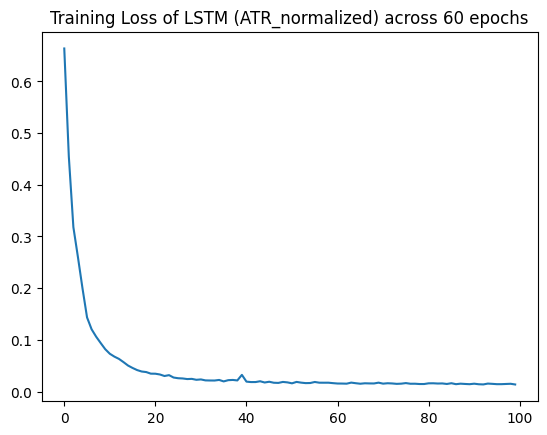

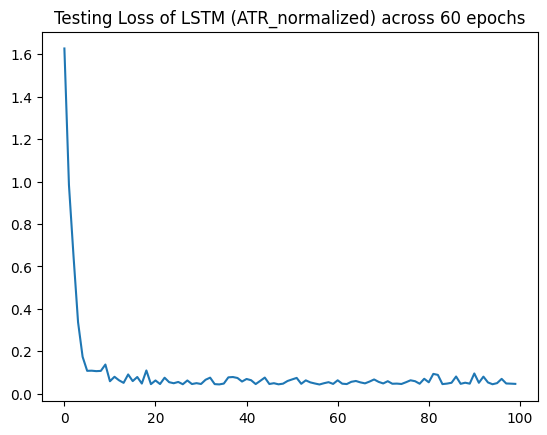

In [27]:
pipeline("XLP",start,end,metric="ATR_normalized")

[*********************100%***********************]  1 of 1 completed
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/416295630.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/416295630.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

read  6419  lines of data for ticker:  XLP
Training Loss: 1.0170903483405709
Training Loss: 0.485907878074795
Training Loss: 0.3001806396059692
Training Loss: 0.22184675107710064
Training Loss: 0.198105342220515
Training Loss: 0.17748539061285556
Training Loss: 0.16352145741693674
Training Loss: 0.1554169308859855
Training Loss: 0.14775939858518541
Training Loss: 0.14799376190640032
Training Loss: 0.13704230785369872
Training Loss: 0.14017540733329953
Training Loss: 0.13742179018445314
Training Loss: 0.13553884192369878
Training Loss: 0.12877884404733778
Training Loss: 0.12480140025727451
Training Loss: 0.12330495899077505
Training Loss: 0.12122220541350544
Training Loss: 0.11472314298152923
Training Loss: 0.11565481326542795
Training Loss: 0.11674488005228341
Training Loss: 0.11302070254459977
Training Loss: 0.11206860654056072
Training Loss: 0.11050232546404004
Training Loss: 0.11014561813790351
Training Loss: 0.1145805393345654
Training Loss: 0.10879022371955216
Training Loss: 0.109

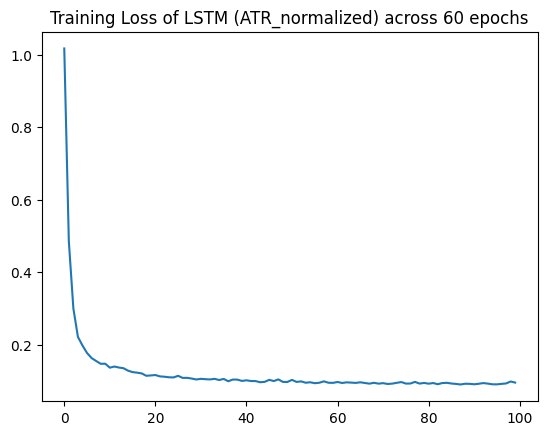

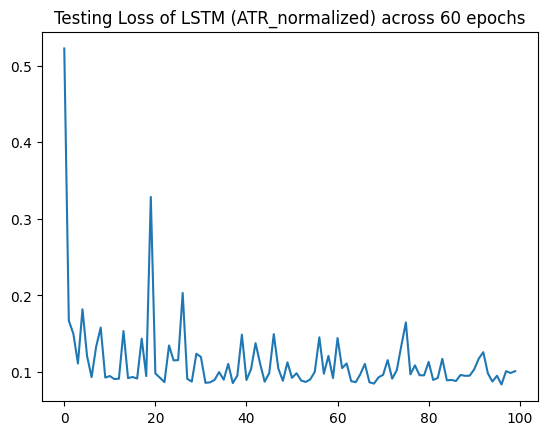

In [28]:
pipeline("XLP",start,end,metric="SD_normalized")

[*********************100%***********************]  1 of 1 completed
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

read  6419  lines of data for ticker:  XLB
Training Loss: 0.5156110554933548
Training Loss: 0.3378131756559014
Training Loss: 0.20827638995833694
Training Loss: 0.1278513008262962
Training Loss: 0.10238449170719832
Training Loss: 0.08535619605099783
Training Loss: 0.07549729766324162
Training Loss: 0.06786034258548171
Training Loss: 0.06316821204964071
Training Loss: 0.058324292511679234
Training Loss: 0.05421211584471166
Training Loss: 0.04796233435627073
Training Loss: 0.045473657723050565
Training Loss: 0.042681513843126594
Training Loss: 0.0384483854402788
Training Loss: 0.03552966696443036
Training Loss: 0.03208091815467924
Training Loss: 0.030619116488378496
Training Loss: 0.028312015091069044
Training Loss: 0.027727186831180008
Training Loss: 0.02691049126442522
Training Loss: 0.025799455284141005
Training Loss: 0.024788971967063846
Training Loss: 0.024282851396128534
Training Loss: 0.023341833654558285
Training Loss: 0.02277935472666286
Training Loss: 0.022932298126397653
Train

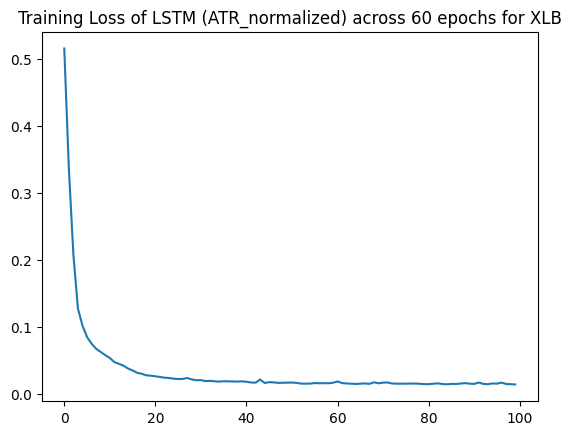

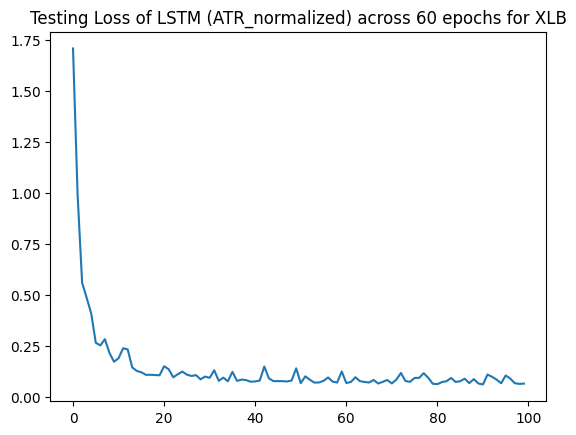

[*********************100%***********************]  1 of 1 completed

read  6419  lines of data for ticker:  XLB



/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Training Loss: 1.0108044613152742
Training Loss: 0.5702132623642683
Training Loss: 0.21948457024991513
Training Loss: 0.15250357487238944
Training Loss: 0.13212978094816208
Training Loss: 0.12004431830719113
Training Loss: 0.11872837771661579
Training Loss: 0.12257175212725997
Training Loss: 0.10743108070455491
Training Loss: 0.1049483637791127
Training Loss: 0.10936968964524567
Training Loss: 0.10326652727089822
Training Loss: 0.1029164561536163
Training Loss: 0.10208081123419106
Training Loss: 0.10053372564725578
Training Loss: 0.09822696465998888
Training Loss: 0.10187556599266827
Training Loss: 0.09968234784901142
Training Loss: 0.09853269597515464
Training Loss: 0.09825759208761156
Training Loss: 0.09876849544234574
Training Loss: 0.09695411305874586
Training Loss: 0.09634554167278112
Training Loss: 0.1009085753466934
Training Loss: 0.10107670358847827
Training Loss: 0.09743595579639078
Training Loss: 0.09547804612666369
Training Loss: 0.09841000051237643
Training Loss: 0.10127701

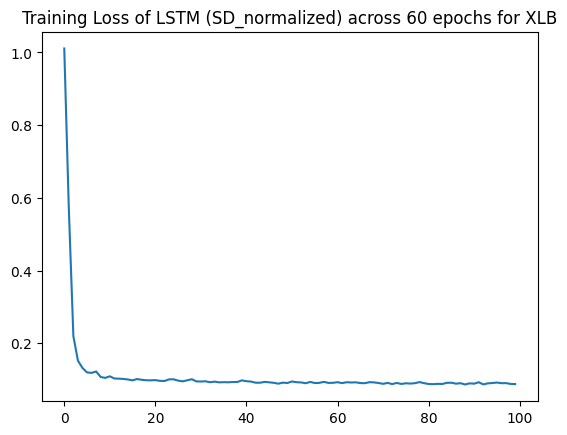

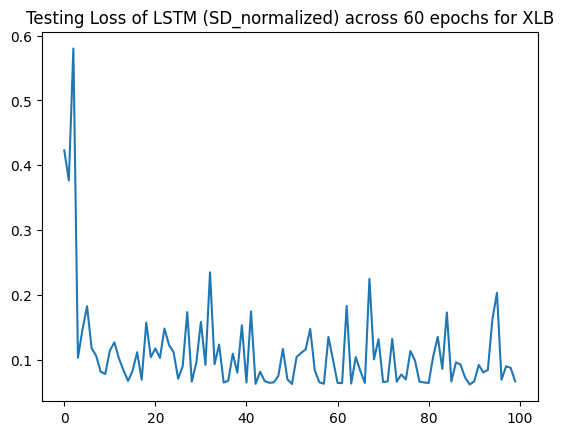

[*********************100%***********************]  1 of 1 completed

read  6419  lines of data for ticker:  XLE



/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Training Loss: 0.7418809799477458
Training Loss: 0.5259735773317515
Training Loss: 0.3064838755875826
Training Loss: 0.1923591431695968
Training Loss: 0.13684564686845987
Training Loss: 0.10308494254713878
Training Loss: 0.08767518004169687
Training Loss: 0.07845157539704814
Training Loss: 0.06735376861179247
Training Loss: 0.06253082132898272
Training Loss: 0.05930503697600216
Training Loss: 0.05352394196670503
Training Loss: 0.04946930045261979
Training Loss: 0.04721298966323957
Training Loss: 0.04516100062755868
Training Loss: 0.04168597878888249
Training Loss: 0.03952525615459308
Training Loss: 0.04002732705557719
Training Loss: 0.03780097153503448
Training Loss: 0.03539231360773556
Training Loss: 0.03448307743528858
Training Loss: 0.03392285363515839
Training Loss: 0.032847183384001256
Training Loss: 0.034190531878266484
Training Loss: 0.03315619213972241
Training Loss: 0.03109694692539051
Training Loss: 0.029926666535902768
Training Loss: 0.028413916099816562
Training Loss: 0.028

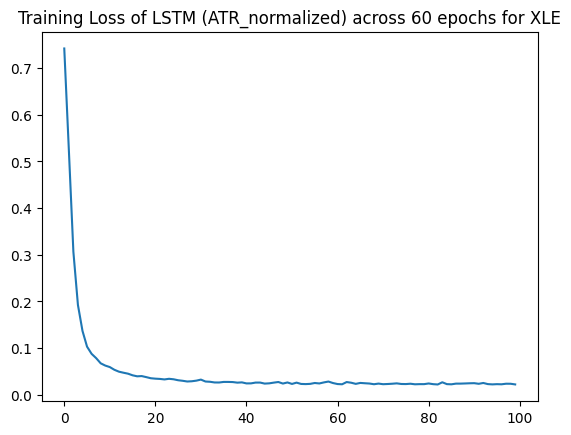

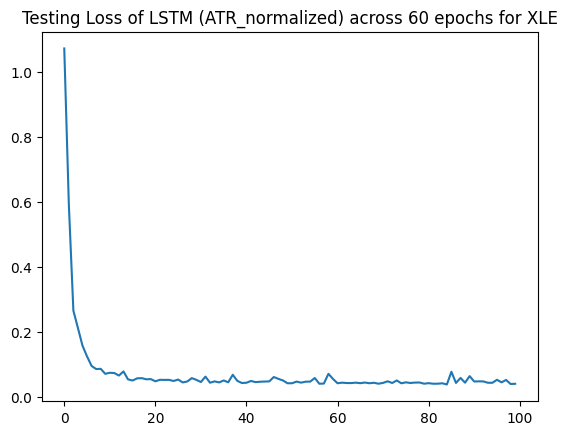

[*********************100%***********************]  1 of 1 completed

read  6419  lines of data for ticker:  XLE



/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Training Loss: 0.8055517767556012
Training Loss: 0.3850294773466885
Training Loss: 0.2477236022707075
Training Loss: 0.18048116648569704
Training Loss: 0.16437974106520414
Training Loss: 0.1358116351533681
Training Loss: 0.12738402727991344
Training Loss: 0.11480255001224578
Training Loss: 0.1107419420965016
Training Loss: 0.10617989148013293
Training Loss: 0.10224285658914596
Training Loss: 0.0959612186299637
Training Loss: 0.09185235174372793
Training Loss: 0.0907473364379257
Training Loss: 0.08813237324357033
Training Loss: 0.08664406123571097
Training Loss: 0.08462087083607912
Training Loss: 0.08722777585498989
Training Loss: 0.0836808925960213
Training Loss: 0.08439740906469524
Training Loss: 0.08594149048440158
Training Loss: 0.07875216512475162
Training Loss: 0.08068748866207898
Training Loss: 0.08041005874983967
Training Loss: 0.08137127691879868
Training Loss: 0.08006549715064466
Training Loss: 0.08461261023767293
Training Loss: 0.08108755084685981
Training Loss: 0.08397717289

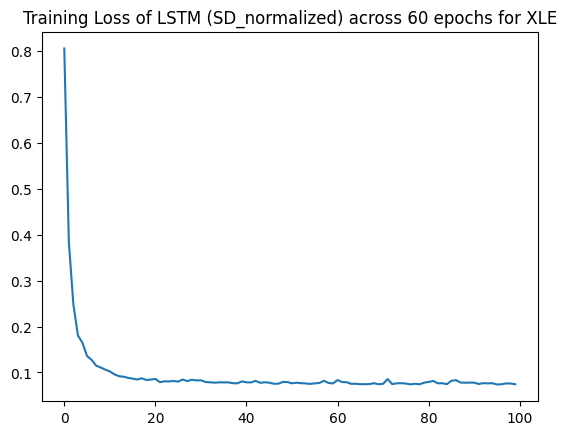

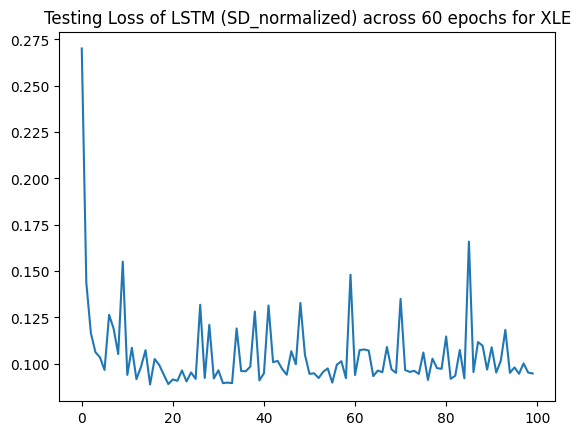

[*********************100%***********************]  1 of 1 completed

read  6419  lines of data for ticker:  XLF



/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Training Loss: 0.5611686009913683
Training Loss: 0.15365326208993793
Training Loss: 0.08056510316673667
Training Loss: 0.057967697980348024
Training Loss: 0.04594711062964052
Training Loss: 0.03926654576789588
Training Loss: 0.03652819129638374
Training Loss: 0.03332140182028524
Training Loss: 0.03181295393733308
Training Loss: 0.029872294375672938
Training Loss: 0.028644811920821668
Training Loss: 0.02753702496411279
Training Loss: 0.02701143834274262
Training Loss: 0.02729303714004345
Training Loss: 0.025124811707064508
Training Loss: 0.02403697445988655
Training Loss: 0.023759923002216965
Training Loss: 0.024009180621942506
Training Loss: 0.02361452299519442
Training Loss: 0.022740226041059942
Training Loss: 0.023207817052025348
Training Loss: 0.02167301666340791
Training Loss: 0.021080678491853178
Training Loss: 0.0209363030618988
Training Loss: 0.021677648922195657
Training Loss: 0.020885442849248648
Training Loss: 0.021634324605111034
Training Loss: 0.020350179501110687
Training 

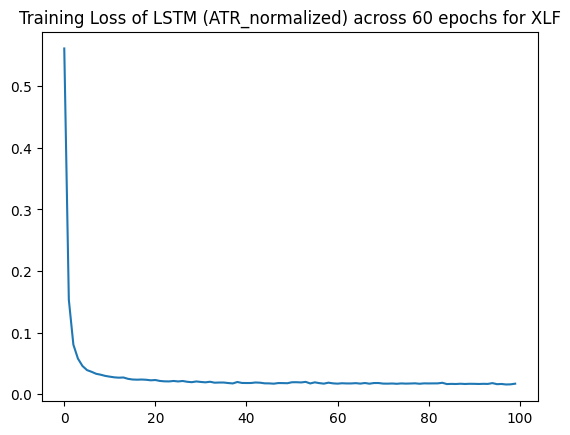

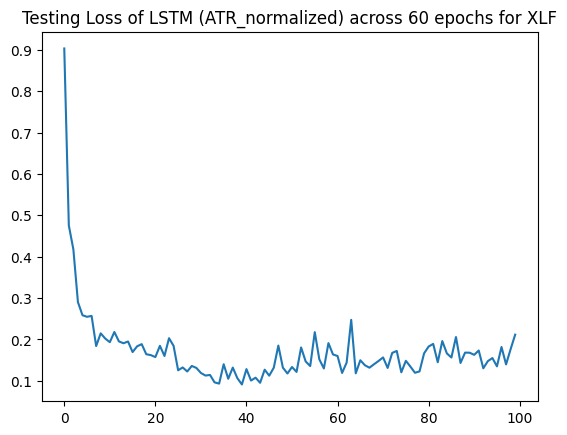

[*********************100%***********************]  1 of 1 completed
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

read  6419  lines of data for ticker:  XLF
Training Loss: 0.873536991328001
Training Loss: 0.29364948803558943
Training Loss: 0.1495415221201256
Training Loss: 0.11429716232232749
Training Loss: 0.09899955198634416
Training Loss: 0.08848790109623224
Training Loss: 0.08146463313605637
Training Loss: 0.07877863517496735
Training Loss: 0.0739692268660292
Training Loss: 0.07970429887063801
Training Loss: 0.0724450257839635
Training Loss: 0.0714369247900322
Training Loss: 0.06853890011552721
Training Loss: 0.07010462277103216
Training Loss: 0.06662814049050211
Training Loss: 0.06660862602293491
Training Loss: 0.06750530609861016
Training Loss: 0.06565148681402207
Training Loss: 0.06600169320590794
Training Loss: 0.06686433455906808
Training Loss: 0.06556060134898871
Training Loss: 0.06704473695717753
Training Loss: 0.06537292308639735
Training Loss: 0.06496531283482909
Training Loss: 0.06767555379774422
Training Loss: 0.06396021461114287
Training Loss: 0.06665745440404862
Training Loss: 0.0

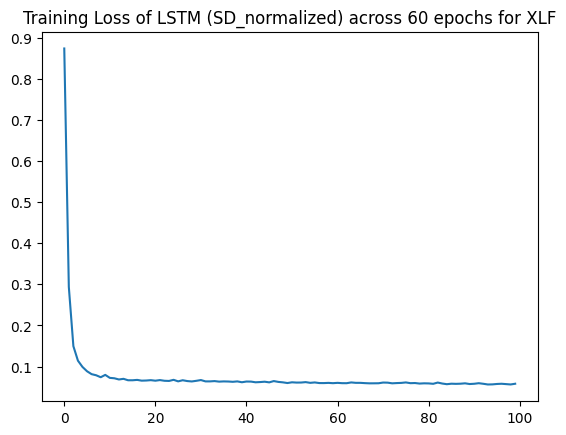

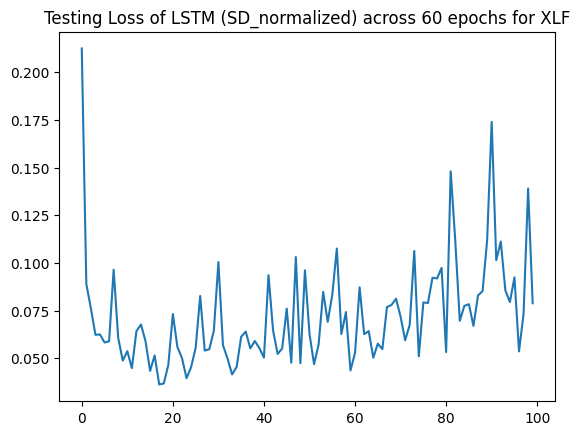

[*********************100%***********************]  1 of 1 completed

read  6419  lines of data for ticker:  XLI



/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Training Loss: 0.42992149395868184
Training Loss: 0.2760016237851232
Training Loss: 0.14879041113890706
Training Loss: 0.09428498188499361
Training Loss: 0.0707822656375356
Training Loss: 0.058420504198875275
Training Loss: 0.048968208854785186
Training Loss: 0.044539609627099706
Training Loss: 0.03740394192282111
Training Loss: 0.03407350006164052
Training Loss: 0.03405526071437635
Training Loss: 0.0311255996406544
Training Loss: 0.026463544578291476
Training Loss: 0.02485414679395035
Training Loss: 0.025599608256015927
Training Loss: 0.023487621115054935
Training Loss: 0.020205656724283472
Training Loss: 0.021618830983061343
Training Loss: 0.01893224837258458
Training Loss: 0.01714932461036369
Training Loss: 0.01671250956133008
Training Loss: 0.01738348088692874
Training Loss: 0.017138537426944822
Training Loss: 0.015607221814570948
Training Loss: 0.015333340037614107
Training Loss: 0.01731132353306748
Training Loss: 0.015088552242377772
Training Loss: 0.013792658963939174
Training L

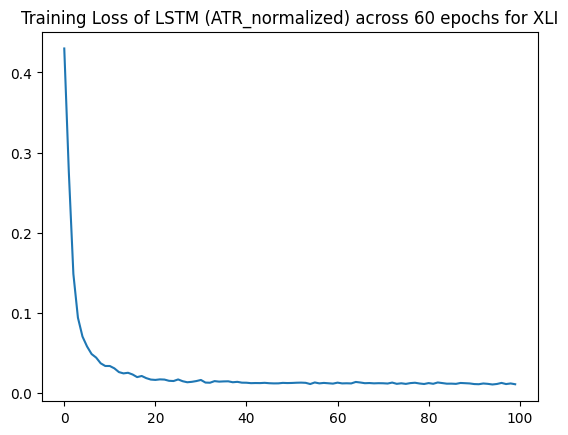

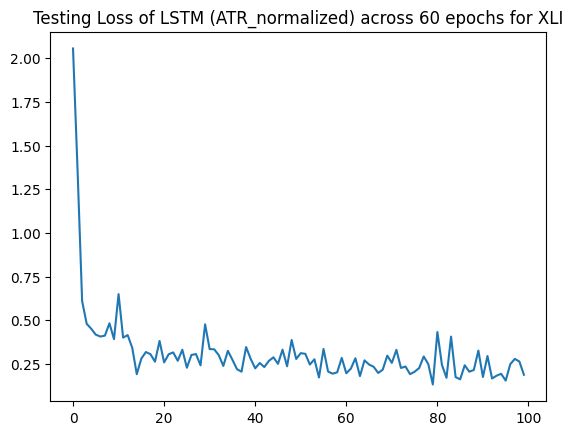

[*********************100%***********************]  1 of 1 completed
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

read  6419  lines of data for ticker:  XLI
Training Loss: 0.9825157199054957
Training Loss: 0.5855290966108442
Training Loss: 0.28229643004015087
Training Loss: 0.1949580291751772
Training Loss: 0.1629491518251598
Training Loss: 0.14253185410052538
Training Loss: 0.1355604123789817
Training Loss: 0.13755974569357932
Training Loss: 0.12087599975056947
Training Loss: 0.1143852953799069
Training Loss: 0.10887768189422786
Training Loss: 0.11232784776948393
Training Loss: 0.10819054353050887
Training Loss: 0.10290013730991632
Training Loss: 0.10257507204078138
Training Loss: 0.10199235137552023
Training Loss: 0.10368818142451346
Training Loss: 0.10243079147767276
Training Loss: 0.10131417717784644
Training Loss: 0.09604368414729833
Training Loss: 0.09530525878071786
Training Loss: 0.09728187439031899
Training Loss: 0.09634792772121728
Training Loss: 0.09906401995103806
Training Loss: 0.09792562075890601
Training Loss: 0.09293092722073197
Training Loss: 0.0929718714673072
Training Loss: 0.09

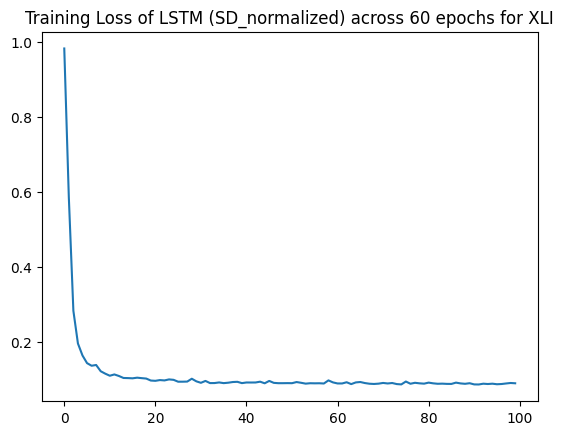

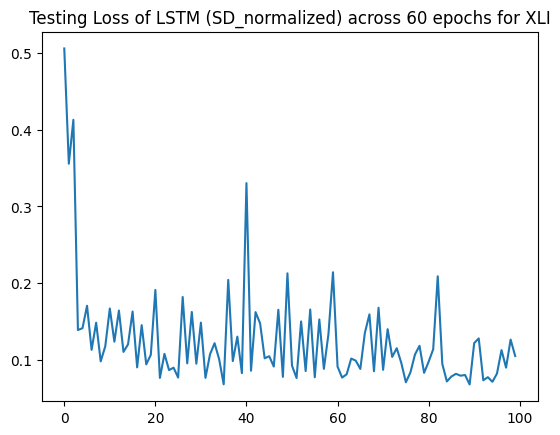

[*********************100%***********************]  1 of 1 completed

read  6419  lines of data for ticker:  XLP



/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Training Loss: 0.6538091011345386
Training Loss: 0.514371744543314
Training Loss: 0.3301331187132746
Training Loss: 0.24008454016875475
Training Loss: 0.18896984348539264
Training Loss: 0.1590725021553226
Training Loss: 0.12327992207137868
Training Loss: 0.10487081512110308
Training Loss: 0.09403001079335808
Training Loss: 0.08393833460868336
Training Loss: 0.07548726043314673
Training Loss: 0.06753681188565679
Training Loss: 0.061669580481247974
Training Loss: 0.05970298871397972
Training Loss: 0.05230571442807559
Training Loss: 0.05000275340280495
Training Loss: 0.046002786577446386
Training Loss: 0.04243945895577781
Training Loss: 0.040362249757163224
Training Loss: 0.0373939931858331
Training Loss: 0.03609591665444896
Training Loss: 0.03407564550288953
Training Loss: 0.03167435072828084
Training Loss: 0.031123835843754933
Training Loss: 0.031438365596113724
Training Loss: 0.029879969917237757
Training Loss: 0.027784664498176424
Training Loss: 0.026581273903138934
Training Loss: 0.0

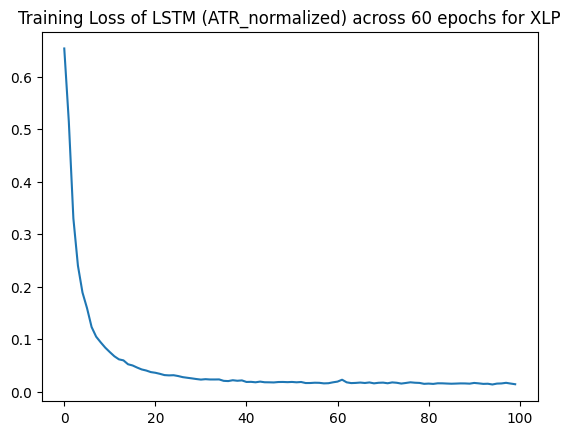

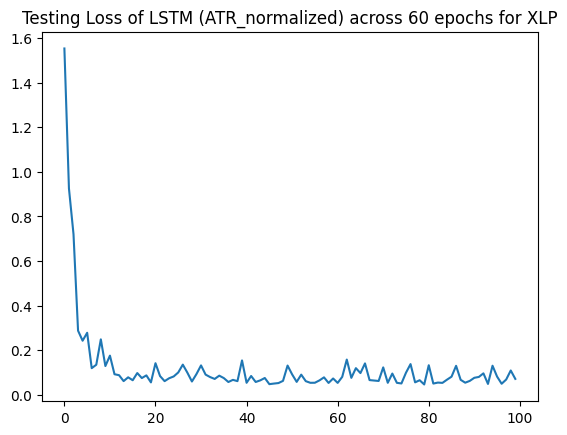

[*********************100%***********************]  1 of 1 completed
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

read  6419  lines of data for ticker:  XLP
Training Loss: 0.9790338814258576
Training Loss: 0.5243473831564188
Training Loss: 0.31367995738983157
Training Loss: 0.2359916004817933
Training Loss: 0.21371704787015916
Training Loss: 0.19307628616224976
Training Loss: 0.17592957341112198
Training Loss: 0.16217231308110058
Training Loss: 0.1549269215669483
Training Loss: 0.14755563205108047
Training Loss: 0.14419477004557849
Training Loss: 0.13734428365714849
Training Loss: 0.13164348285645247
Training Loss: 0.1287254377268255
Training Loss: 0.12542375535704195
Training Loss: 0.12147324550896883
Training Loss: 0.12156414254568518
Training Loss: 0.12112370624672622
Training Loss: 0.11809210181236267
Training Loss: 0.11672114604152739
Training Loss: 0.12081920595373959
Training Loss: 0.11478664292953908
Training Loss: 0.10971885891631246
Training Loss: 0.11237980597652494
Training Loss: 0.10749445911496877
Training Loss: 0.11355763757601381
Training Loss: 0.10273821880109608
Training Loss: 0.

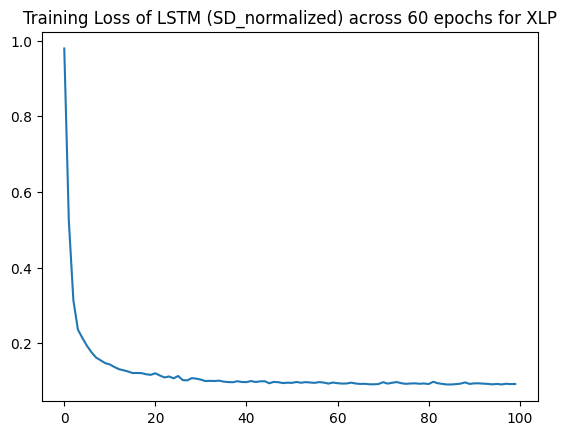

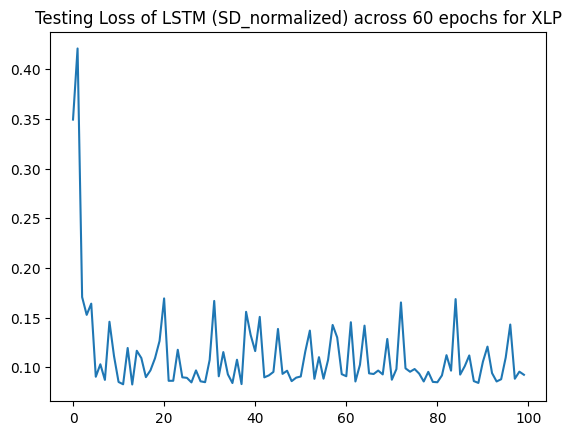

[*********************100%***********************]  1 of 1 completed
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

read  6419  lines of data for ticker:  XLV
Training Loss: 0.47090777223929764
Training Loss: 0.3723281810525805
Training Loss: 0.28224572993349284
Training Loss: 0.24296039778273554
Training Loss: 0.19817064835224302
Training Loss: 0.16584864363539964
Training Loss: 0.13234760486520827
Training Loss: 0.10774097119574436
Training Loss: 0.09648603206733242
Training Loss: 0.08422519012819976
Training Loss: 0.0725444822688587
Training Loss: 0.06555026368587277
Training Loss: 0.05828342210734263
Training Loss: 0.05268533063936047
Training Loss: 0.048990191251505166
Training Loss: 0.040941414644476024
Training Loss: 0.03904370196978561
Training Loss: 0.0366097983205691
Training Loss: 0.034076253935927524
Training Loss: 0.03173902091803029
Training Loss: 0.030326039320789276
Training Loss: 0.030463214998599143
Training Loss: 0.03050653807586059
Training Loss: 0.026127459347480907
Training Loss: 0.02605038898764178
Training Loss: 0.024972203298239036
Training Loss: 0.025224977181642315
Trainin

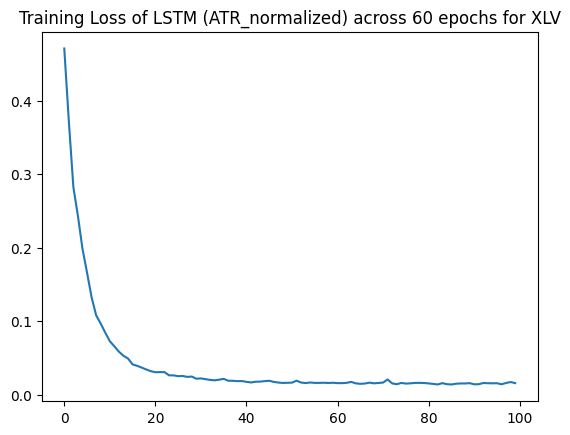

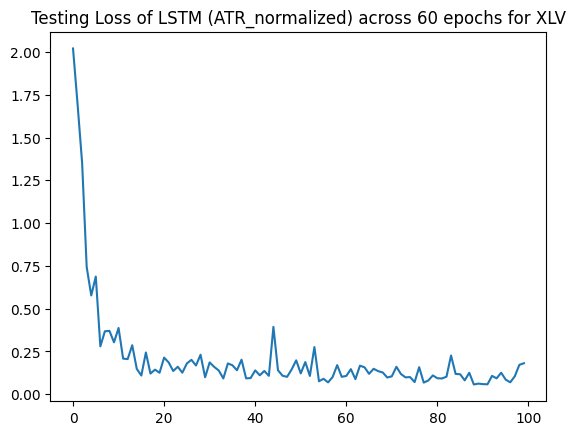

[*********************100%***********************]  1 of 1 completed

read  6419  lines of data for ticker:  XLV



/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Training Loss: 0.9968820512294769
Training Loss: 0.6249059341847897
Training Loss: 0.3246101615950465
Training Loss: 0.22080286145210265
Training Loss: 0.17193285305984318
Training Loss: 0.15767818479798734
Training Loss: 0.14476918377913534
Training Loss: 0.13318286282010378
Training Loss: 0.12610258706845343
Training Loss: 0.12380536869168282
Training Loss: 0.12446796223521232
Training Loss: 0.11531303930096329
Training Loss: 0.1105103581910953
Training Loss: 0.10944495536386967
Training Loss: 0.10606753309257329
Training Loss: 0.1059473639819771
Training Loss: 0.10196448834612966
Training Loss: 0.10378965814597904
Training Loss: 0.10153833590447903
Training Loss: 0.10246608722954989
Training Loss: 0.0984793305862695
Training Loss: 0.09973265836015344
Training Loss: 0.09606129620224238
Training Loss: 0.1001387739321217
Training Loss: 0.09906033393926919
Training Loss: 0.09765315111726522
Training Loss: 0.0983505554497242
Training Loss: 0.09948440822772682
Training Loss: 0.10288753444

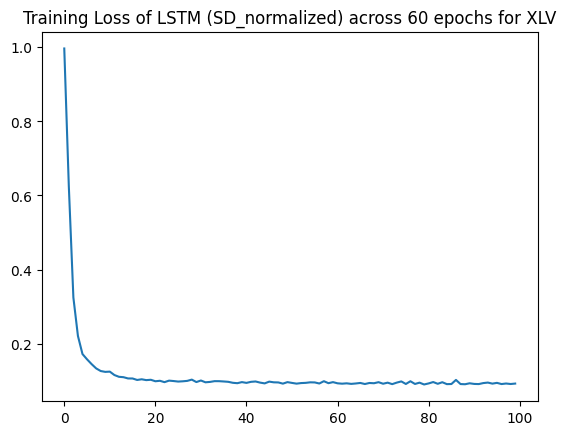

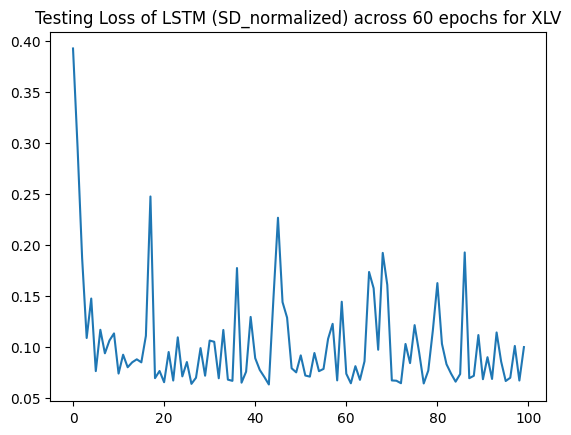

[*********************100%***********************]  1 of 1 completed
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

read  6419  lines of data for ticker:  XLY
Training Loss: 0.18172519092913716
Training Loss: 0.13777297108899803
Training Loss: 0.10855400966247544
Training Loss: 0.08433279410819523
Training Loss: 0.06261477827501949
Training Loss: 0.05008153712551575
Training Loss: 0.04084290296013933
Training Loss: 0.03541743026580661
Training Loss: 0.03352991176652722
Training Loss: 0.03155166997894412
Training Loss: 0.026911085940082558
Training Loss: 0.025164159500855023
Training Loss: 0.022704769474512432
Training Loss: 0.02467083001683932
Training Loss: 0.019011901404883246
Training Loss: 0.022892359808611217
Training Loss: 0.022769977209100033
Training Loss: 0.02022275830095168
Training Loss: 0.019207618897780776
Training Loss: 0.016711303977353965
Training Loss: 0.016476696587051264
Training Loss: 0.01411565555317793
Training Loss: 0.013435739162378012
Training Loss: 0.012634450738551095
Training Loss: 0.013913315537502058
Training Loss: 0.011125084589002654
Training Loss: 0.01235345152381342

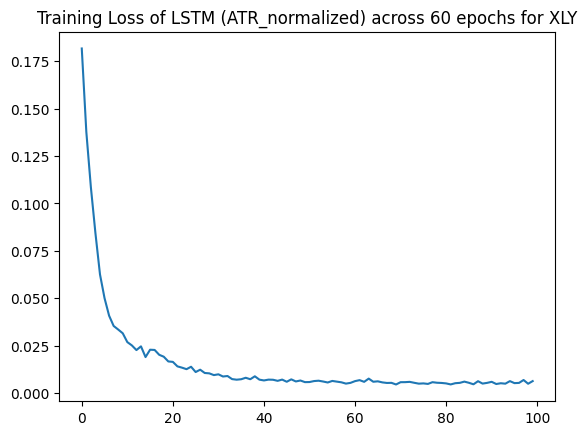

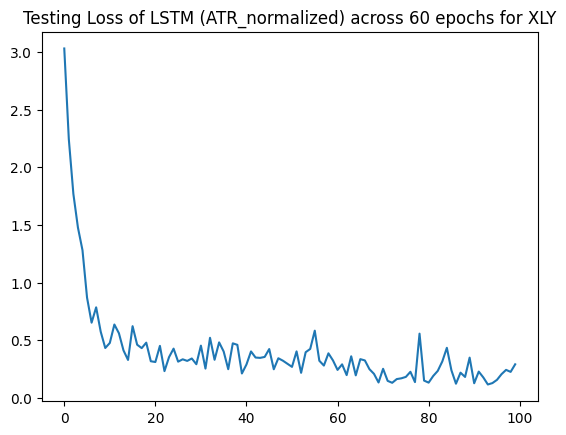

[*********************100%***********************]  1 of 1 completed

read  6419  lines of data for ticker:  XLY



/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Training Loss: 0.8269098063930869
Training Loss: 0.5378998494707048
Training Loss: 0.33278699181973936
Training Loss: 0.22880326388403774
Training Loss: 0.18355385875329375
Training Loss: 0.165907292207703
Training Loss: 0.14310074960812927
Training Loss: 0.13941033519804477
Training Loss: 0.12614245624281467
Training Loss: 0.11976686911657453
Training Loss: 0.10922874882817268
Training Loss: 0.10875350181013346
Training Loss: 0.10246693568769842
Training Loss: 0.10502843982540071
Training Loss: 0.09972402579151093
Training Loss: 0.09675068659707904
Training Loss: 0.0983488499186933
Training Loss: 0.0953357454854995
Training Loss: 0.09644238769542426
Training Loss: 0.09577432919759303
Training Loss: 0.10468500973656773
Training Loss: 0.10173837477341294
Training Loss: 0.10257270629517734
Training Loss: 0.09622216001152992
Training Loss: 0.0965792250353843
Training Loss: 0.09486445479560643
Training Loss: 0.09541270413901656
Training Loss: 0.0933758954051882
Training Loss: 0.09565714127

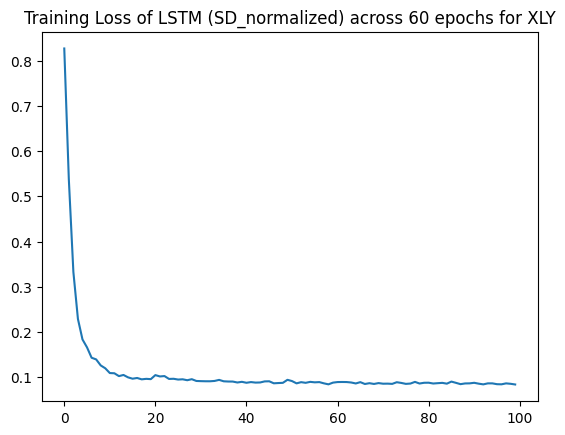

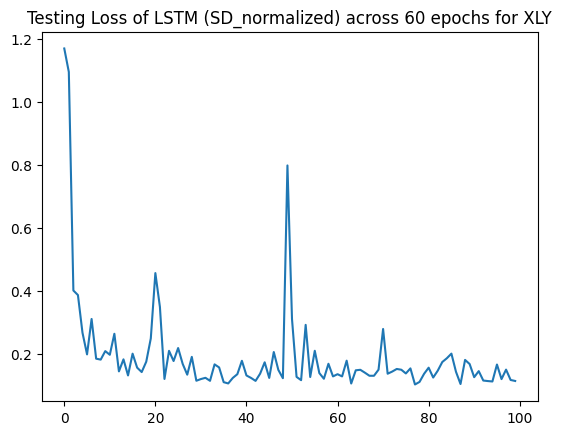

[*********************100%***********************]  1 of 1 completed
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

read  6419  lines of data for ticker:  XLU
Training Loss: 0.6550921289250254
Training Loss: 0.3893470820039511
Training Loss: 0.2688534597400576
Training Loss: 0.21309477266622706
Training Loss: 0.16271681608632207
Training Loss: 0.1309708465007134
Training Loss: 0.1128038322320208
Training Loss: 0.09197648630943149
Training Loss: 0.07917649201699532
Training Loss: 0.07592922325129621
Training Loss: 0.0702169981377665
Training Loss: 0.06033250622567721
Training Loss: 0.05851548088248819
Training Loss: 0.05239837989793159
Training Loss: 0.044649258331628514
Training Loss: 0.04108324656845071
Training Loss: 0.03706700024195016
Training Loss: 0.035760813142405826
Training Loss: 0.032470664783613754
Training Loss: 0.032181077869609
Training Loss: 0.030659319134429097
Training Loss: 0.029104843869572506
Training Loss: 0.02782981328200549
Training Loss: 0.025409153621876613
Training Loss: 0.025043381610885262
Training Loss: 0.02368285259581171
Training Loss: 0.02359146979288198
Training Loss

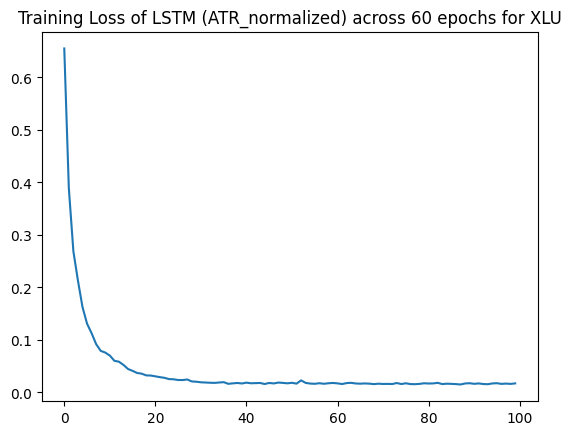

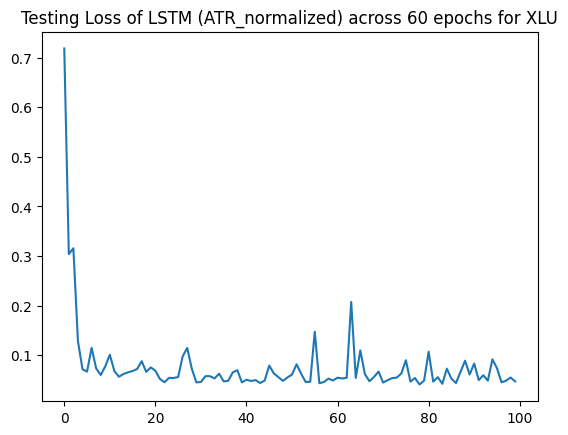

[*********************100%***********************]  1 of 1 completed
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_48013/1286385128.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

read  6419  lines of data for ticker:  XLU
Training Loss: 1.070466901548207
Training Loss: 0.6468085361644625
Training Loss: 0.33733944450505077
Training Loss: 0.20148258600383998
Training Loss: 0.1583849192596972
Training Loss: 0.14363579410128297
Training Loss: 0.1301904612686485
Training Loss: 0.12168194986879825
Training Loss: 0.11914567295461893
Training Loss: 0.1140571772120893
Training Loss: 0.10772460736334324
Training Loss: 0.10606040335260332
Training Loss: 0.10066041285172105
Training Loss: 0.09807231980375945
Training Loss: 0.10167490364983678
Training Loss: 0.09623170986305922
Training Loss: 0.09088476533070207
Training Loss: 0.09201444420032204
Training Loss: 0.09380301046185195
Training Loss: 0.09189759462606162
Training Loss: 0.0878751919604838
Training Loss: 0.08646473039407283
Training Loss: 0.08861204301938415
Training Loss: 0.08583760200999677
Training Loss: 0.08955798409879208
Training Loss: 0.0848794101504609
Training Loss: 0.08849637066014111
Training Loss: 0.084

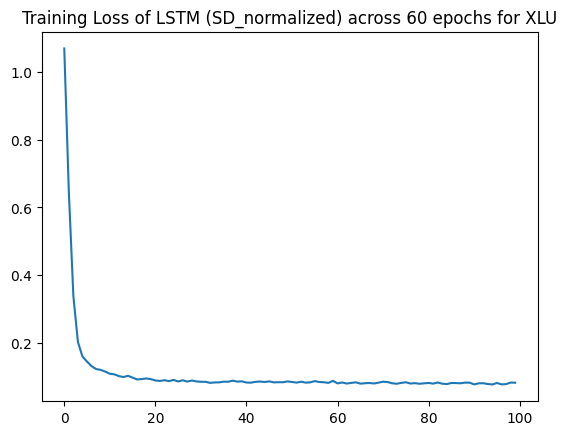

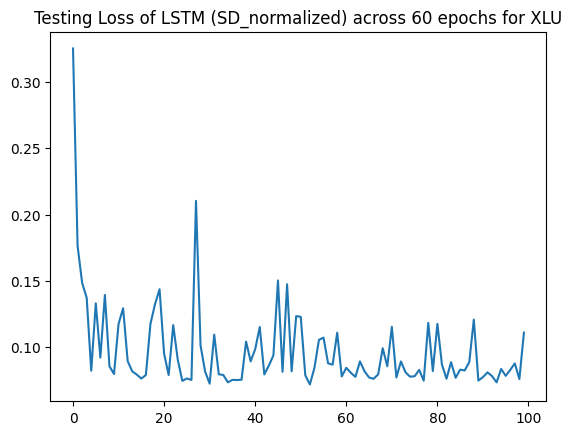

In [35]:
etfs = ['XLB','XLE','XLF','XLI','XLP','XLV','XLY','XLU']
metrics = ["ATR_normalized","SD_normalized"]
df = pd.DataFrame({"etf":[],"metric":[],"train_loss":[],"test_loss":[]})
for etf in etfs:
    for metric in metrics:
        train_loss_atr, test_loss_atr = pipeline(etf,start,end,metric=metric)
        df.loc[len(df)] = [etf,train_loss_atr,test_loss_atr,metric,]


In [36]:
df

,etf,metric,train_loss,test_loss
0,XLB,0.014649,0.061977,ATR_normalized
1,XLB,0.086862,0.061875,SD_normalized
2,XLE,0.022033,0.037518,ATR_normalized
3,XLE,0.073796,0.088796,SD_normalized
4,XLF,0.015971,0.091201,ATR_normalized
5,XLF,0.056364,0.036298,SD_normalized
6,XLI,0.011027,0.132755,ATR_normalized
7,XLI,0.085534,0.068298,SD_normalized
8,XLP,0.013798,0.045955,ATR_normalized
9,XLP,0.091183,0.082711,SD_normalized
